<a href="https://colab.research.google.com/github/asantos2000/master-degree-santos-anderson/blob/main/code/src/chap_7_validation_rules_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validation

Validation of algorithms and transformation results.

Chap 7. Validação
- Section 7.3 Resultados
    - Section 7.3.2 Semantic Annotation
        - Classificação de regras operativas, fatos, termos e nomes
    - Section 7.3.3 nlp2sbvr


> To run again, restore checkpoint directory with file *-1 to *-10 from `checkpoints_classification` directory.

## Google colab

In [144]:
%load_ext autoreload
%autoreload 2

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  !rm -rf cfr2sbvr configuration checkpoint
  !git clone https://github.com/asantos2000/master-degree-santos-anderson.git cfr2sbvr
  %pip install -r cfr2sbvr/code/requirements.txt
  !cp -r cfr2sbvr/code/src/configuration .
  !cp -r cfr2sbvr/code/src/checkpoint .
  !cp -r cfr2sbvr/code/config.colab.yaml config.yaml
  DEFAULT_CONFIG_FILE="config.yaml"
else:
  DEFAULT_CONFIG_FILE="../config.yaml"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [145]:
# Standard library imports
from collections import defaultdict
from datetime import datetime
import json
import time
from typing import List
import os
import re
from collections import Counter

# Third-party imports
import jellyfish
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from openai import OpenAI
from scipy.spatial.distance import cosine
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
import xlsxwriter
from openpyxl import load_workbook
import openpyxl
from pydantic import BaseModel, Field

# Local application/library-specific imports
import checkpoint.main as checkpoint
from checkpoint.main import (
    normalize_str,
    restore_checkpoint,
    get_all_checkpoints,
    get_elements_from_checkpoints,
    get_elements_from_true_tables,
    Document,
)
import configuration.main as configuration
import logging_setup.main as logging_setup
import token_estimator.main as token_estimator
from token_estimator.main import estimate_tokens
import llm_query.main as llm_query
from llm_query.main import query_instruct_llm
import rules_taxonomy_provider.main as rules_taxonomy_provider
from rules_taxonomy_provider.main import RulesTemplateProvider

DEV_MODE = True

if DEV_MODE:
    # Development mode
    import importlib

    importlib.reload(configuration)
    importlib.reload(logging_setup)
    importlib.reload(checkpoint)
    importlib.reload(token_estimator)
    importlib.reload(llm_query)
    importlib.reload(rules_taxonomy_provider)

# Ensure plots are displayed inline if using a Jupyter notebook
%matplotlib inline

from IPython.display import display

## Settings

### Configuration

In [146]:
# Load configuration
config = configuration.load_config(DEFAULT_CONFIG_FILE)

### Logging

In [147]:
logger = logging_setup.setting_logging(config["DEFAULT_LOG_DIR"], config["LOG_LEVEL"])

2024-12-22 00:50:04 - INFO - Logging is set up with daily rotation.


## Checkpoints

### Restore the checkpoint

In [148]:
# Restore the checkpoint

# To run after extraction
last_checkpoint = configuration.get_last_filename(
    config["DEFAULT_CHECKPOINT_DIR"], "documents", "json"
)

logger.info(f"{last_checkpoint=}")

config["DEFAULT_CHECKPOINT_FILE"] = last_checkpoint

manager = restore_checkpoint(filename=config["DEFAULT_CHECKPOINT_FILE"])

2024-12-22 00:50:04 - INFO - last_checkpoint='../data/checkpoints/documents-2024-12-07-10.json'
2024-12-22 00:50:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-07-10.json
2024-12-22 00:50:04 - INFO - Checkpoint restored from ../data/checkpoints/documents-2024-12-07-10.json.


## General functions

In [149]:
def generate_metrics_with_report(pred_docs, true_docs, key_to_compare, element_name):
    """
    Matches predicted and true documents to extract a specified key's values, then generates
    a confusion matrix and classification report. Plots the confusion matrix and prints the report.
    Returns the confusion matrix and classification report as DataFrames.

    Args:
        pred_docs (list): List of predicted document dictionaries.
        true_docs (list): List of true document dictionaries.
        key_to_compare (str): The key to compare between predicted and true documents.

    Returns:
        tuple: A tuple containing:
            - cm_df (DataFrame): The confusion matrix as a DataFrame.
            - report_df (DataFrame): The classification report as a DataFrame.
            - not_match (list): List of predicted documents with no matching true document.
            - mismatched_docs (list): List of tuples containing the true document and predicted document where y_true differs from y_pred.
    """

    # Normalize sources to avoid mismatches due to ordering or case sensitivity
    def normalize_sources(sources):
        return tuple(sorted([source.strip().lower() for source in sources]))

    # Create a dictionary for true_docs lookup by (doc_id, sources, statement_id)
    true_dict = {
        (
            d["doc_id"],
            normalize_sources(d["sources"]),
            str(d.get("statement_id", "")),
        ): d
        for d in true_docs
    }

    # Initialize true and predicted values
    y_true = []
    y_pred = []
    not_match = []
    mismatched_docs = []

    # Match predicted documents and extract values
    for pred_doc in pred_docs:
        # Generate the key to find the true document
        key = (
            pred_doc["doc_id"],
            normalize_sources(pred_doc["sources"]),
            str(pred_doc.get("statement_id", "")),
        )
        true_doc = true_dict.get(key)
        logger.debug(f"{pred_doc=}")
        # Append the appropriate values for y_true and y_pred
        if true_doc:
            y_true_value = true_doc.get(
                key_to_compare, "No Key"
            )  # Default if key is missing
            y_pred_value = pred_doc.get(
                key_to_compare, "No Key"
            )  # Default if key is missing

            # Add to y_true and y_pred
            y_true.append(y_true_value)
            y_pred.append(y_pred_value)

            # Check for mismatched values between y_true and y_pred
            if y_true_value != y_pred_value:
                mismatched_docs.append((true_doc, pred_doc))

        else:
            # Attempt fallback matching based on doc_id and sources if exact match not found
            fallback_matches = [
                true
                for (doc_id, sources, _), true in true_dict.items()
                if doc_id == pred_doc["doc_id"]
                and sources == normalize_sources(pred_doc["sources"])
            ]
            if fallback_matches:
                true_doc = fallback_matches[0]
                y_true_value = true_doc.get(key_to_compare, "No Key")
                y_pred_value = pred_doc.get(key_to_compare, "No Key")

                # Add to y_true and y_pred
                y_true.append(y_true_value)
                y_pred.append(y_pred_value)

                # Check for mismatched values between y_true and y_pred
                if y_true_value != y_pred_value:
                    mismatched_docs.append((true_doc, pred_doc))

            else:
                # If no match at all, add to not_match
                not_match.append(pred_doc)
            # not_match.append(pred_doc)

    # Ensure all labels are strings to avoid comparison issues
    y_true = [str(label) for label in y_true]
    y_pred = [str(label) for label in y_pred]

    # Generate confusion matrix
    labels = sorted(set(y_true + y_pred))  # Unique classes, sorted for consistency
    # labels = sorted(set(y_true))  # Classes that actually appear in the ground truth
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_df, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel(f"Predicted {key_to_compare.capitalize()}")
    plt.ylabel(f"True {key_to_compare.capitalize()}")
    plt.title(
        f"Confusion Matrix for {element_name.capitalize()}: {key_to_compare.capitalize()}"
    )
    plt.show()

    # Print classification report
    report = classification_report(
        y_true, y_pred, labels=labels, output_dict=True, zero_division=0
    )
    print("\nClassification Report:")
    print(
        classification_report(
            y_true, y_pred, labels=labels, output_dict=False, zero_division=0
        )
    )

    # Convert classification report to DataFrame
    report_df = pd.DataFrame(report).transpose()

    return cm_df, report_df, not_match, mismatched_docs

In [150]:
def remove_section_symbol(input_string: str) -> str:
    """
    Removes the '§' symbol from the input string and trims whitespace.

    Args:
        input_string (str): The string from which to remove the '§' symbol.

    Returns:
        str: The cleaned string without the '§' symbol and leading/trailing whitespace.

    Raises:
        TypeError: If 'input_string' is not a string.
    """
    if not isinstance(input_string, str):
        raise TypeError("input_string must be a string")
    return input_string.replace("§", "").strip()

In [151]:
def save_metrics_to_excel(dataframes_list, output_excel_path):
    """
    Saves multiple DataFrames to an Excel file, each as a separate sheet.

    Args:
        dataframes_list (list): List of tuples, where each tuple contains:
            - sheet_name (str): The name of the sheet.
            - dataframe (DataFrame): The DataFrame to save.
        output_excel_path (str): Path to save the Excel file.

    Returns:
        None
    """
    # Clean up sheet names to contain only letters, spaces, and numbers
    sanitized_dataframes = [
        (re.sub(r"[^A-Za-z0-9 ]+", "", sheet_name).strip(), df)
        for sheet_name, df in dataframes_list
    ]

    # Check if the file exists
    file_exists = os.path.exists(output_excel_path)

    if file_exists:
        # Load existing workbook
        book = load_workbook(output_excel_path)
        # Append to the existing file
        with pd.ExcelWriter(output_excel_path, engine="openpyxl", mode="a", if_sheet_exists="overlay") as writer:
            for sheet_name, df in sanitized_dataframes:
                # Remove the sheet if it exists in the workbook
                if sheet_name in book.sheetnames:
                    del book[sheet_name]
                # Write to Excel
                df.to_excel(writer, sheet_name=sheet_name, index=False)
    else:
        # Create a new workbook
        with pd.ExcelWriter(output_excel_path, engine="openpyxl", mode="w") as writer:
            for sheet_name, df in sanitized_dataframes:
                df.to_excel(writer, sheet_name=sheet_name, index=False)


In [152]:
# Add similarity_classification based on similarity_score
def classify_similarity(score):
    if score == 1.0:
        return "identical"
    elif score >= 0.9:
        return "close-match"
    else:
        return "not-sure"


# Modify the highlight_similarity function to use three colors
def highlight_similarity(val):
    if val == "identical":
        color = "green"
    elif val == "close-match":
        color = "yellow"
    else:
        color = "red"
    return f"background-color: {color}"

In [153]:
def create_df_elements_results(similarity_elements_results):
    # Build the dataframe
    df_results = pd.DataFrame(similarity_elements_results)

    df_results["similarity_classification"] = df_results["similarity_score"].apply(
        classify_similarity
    )

    df_results["classification_match"] = (
        df_results["classification_pred"] == df_results["classification_true"]
    )
    df_results["classification_match_label"] = df_results["classification_match"].map(
        {True: "match", False: "mismatch"}
    )

    df_results["source_match"] = df_results["source_pred"] == df_results["source_true"]
    df_results["source_match_label"] = df_results["source_match"].map(
        {True: "match", False: "mismatch"}
    )

    df_results["id_match"] = df_results["id_pred"] == df_results["id_true"]
    df_results["id_match_label"] = df_results["id_match"].map(
        {True: "match", False: "mismatch"}
    )

    return df_results

## Datasets

From section 7.2.4 Datasets

The dataset of the previous algorithm was adjusted with the gold standard dataset. The goal is to reduce the accumulation of errors from one step to the next.

The data adjusted:

- § 275.0-2_P1, § 275.0-2_P2
- § 275.0-5_P1, § 275.0-5_P2
- § 275.0-7_P1, § 275.0-7_P2

### True tables

Get true values from true tables for classification.

In [154]:
(
    true_operative_rules_p1_classify,
    true_facts_classify,
    true_names_classify,
    true_terms_classify,
    true_operative_rules_p2_classify,
) = get_elements_from_true_tables(config["DEFAULT_DATA_DIR"])

2024-12-22 00:50:05 - INFO - DocumentManager restored from file: ../data/documents_true_table.json
2024-12-22 00:50:05 - INFO - Checkpoint restored from ../data/documents_true_table.json.
2024-12-22 00:50:05 - INFO - P1: Operative Rules to evaluate: 6
2024-12-22 00:50:05 - INFO - P2: Facts to evaluate: 16
2024-12-22 00:50:05 - INFO - P2: Names to evaluate: 5
2024-12-22 00:50:05 - INFO - P2: Terms to evaluate: 28
2024-12-22 00:50:05 - INFO - P2: Operative Rules to evaluate: 6


Get predicted values from all runs for classification.

### Predicted values

Get predicted elements from all runs

In [155]:
(
    pred_operative_rules_classify,
    pred_facts_classify,
    pred_terms_classify,
    pred_names_classify,
    pred_files_classify,
) = get_elements_from_checkpoints(
    config["DEFAULT_CHECKPOINT_DIR"], merge=True, filter="non_null"
)

2024-12-22 00:50:05 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-07-1.json
2024-12-22 00:50:05 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-07-10.json
2024-12-22 00:50:05 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-07-2.json
2024-12-22 00:50:05 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-07-3.json
2024-12-22 00:50:05 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-07-4.json
2024-12-22 00:50:05 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-07-5.json
2024-12-22 00:50:05 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-07-6.json
2024-12-22 00:50:05 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-07-7.json
2024-12-22 00:50:05 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-

2024-12-22 00:50:05 - INFO - Rules to evaluate: 60
2024-12-22 00:50:05 - INFO - Facts to evaluate: 160
2024-12-22 00:50:05 - INFO - Terms to evaluate: 280
2024-12-22 00:50:05 - INFO - Names to evaluate: 50


## Algorithms

Validation of algorithm from section 6.2 Implementation of main components

Source for section 7.3 Results 

### semantic annotation

#### Classify elements

Validating results from chap_6_semantic_annotation_elements_classification.ipynb

- Classify operative rules by top-level taxonomy: Activity, Data, Party
- Classify elements by taxonomy and get templates
    - operative rules
    - facts
    - terms
    - names

##### Operative rules

Validate taxonomy top-level classification. (P1)

In [156]:
# Save all metrics to a single Excel file
dataframes_list = []

Compare predict and true values for attribute "type"

In [157]:
len(pred_operative_rules_classify), len(true_operative_rules_p1_classify)

(60, 6)

In [158]:
pred_operative_rules_classify

[{'doc_id': '§ 275.0-2',
  'statement_id': 3,
  'statement_title': 'Forwarding documents by the Secretary',
  'statement': "The Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission.",
  'sources': ['(a)(2)'],
  'terms': [{'term': 'Last address',
    'classification': 'Common Noun',
    'confidence': 0.8,
    'reason': 'The term refers to the address on file for the named party.',
    'extracted_confidence': 0.8,
    'extracted_reason': 'The term is mentioned as the location to which documents are sent.'},
   {'term': 'Last address filed with the Commission',
    'classification': 'Common Noun',
    'confidence': 0.8,
    'reason': 'The term refers to the location where documents are sent.',
    'extracted_confidence': 0.8,
    'extracted_reason': 'The term is implied as part of the service process.'},
   {'term': 'Process',
    'classification': 'Common Noun',
    

In [159]:
# To get per doc_id use the pred_fitered_list
# pred_fitered_list = [pred_doc for pred_doc in pred_operative_rules_classify if pred_doc["doc_id"] == "§ 275.0-7"]
pred_fitered_list = pred_operative_rules_classify # All


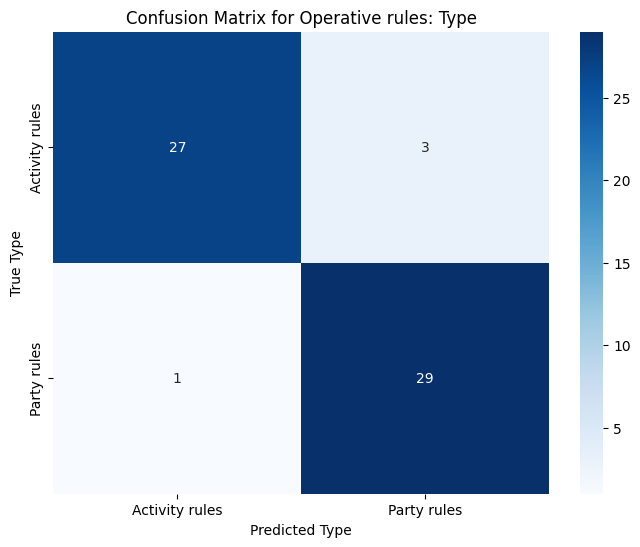


Classification Report:
                precision    recall  f1-score   support

Activity rules       0.96      0.90      0.93        30
   Party rules       0.91      0.97      0.94        30

      accuracy                           0.93        60
     macro avg       0.94      0.93      0.93        60
  weighted avg       0.94      0.93      0.93        60

0
[]
4
[({'doc_id': '§ 275.0-5', 'statement_id': '4', 'statement': 'The Commission will order a hearing on the matter, if it appears that a hearing is necessary or appropriate in the public interest or for the protection of investors, upon the request of any interested person or upon its own motion.', 'sources': ['(c)'], 'type': 'Activity rules'}, {'doc_id': '§ 275.0-5', 'statement_id': 4, 'statement_title': 'Commission orders a hearing', 'statement': 'The Commission will order a hearing on the matter, if it appears that a hearing is necessary or appropriate in the public interest or for the protection of investors, upon the requ

In [160]:
key = "type"
element_name = "operative rules"

cm_df, report_df, no_match, mismatch_docs = generate_metrics_with_report(
    [pred_doc for pred_doc in pred_fitered_list if "type" in pred_doc],
    true_operative_rules_p1_classify,
    key,
    element_name,
)

print(len(no_match))
print(no_match)
print(len(mismatch_docs))
print(mismatch_docs)

dataframes_list.append((f"{element_name} - CM {key}", cm_df))
dataframes_list.append((f"{element_name} - CR {key}", report_df))

List not matched rules.

In [161]:
for rule in no_match:
    logger.info(json.dumps({
        "doc_id": f"{rule['doc_id']}",
        "statement_id": f"{rule['statement_id']}",
        "statement": f"{rule['statement']}",
        "sources": f"{rule['sources']}",
        "subtype": f"{rule['subtype']}",
        "templates_ids": f"{rule['templates_ids']}",
    }))

In [162]:
sorted([
    f'{doc[0]["doc_id"]} - {doc[0]["sources"]} - {doc[0]["statement"]} - {doc[0]["type"]} - {doc[1]["type"]}'
    for doc in mismatch_docs
])

["§ 275.0-5 - ['(a)'] - Any interested person may, within the period of time specified therein, submit to the Commission in writing any facts bearing upon the desirability of a hearing on the matter and may request that a hearing be held, stating his reasons therefor and the nature of his interest in the matter. - Party rules - Activity rules",
 "§ 275.0-5 - ['(c)'] - The Commission will order a hearing on the matter, if it appears that a hearing is necessary or appropriate in the public interest or for the protection of investors, upon the request of any interested person or upon its own motion. - Activity rules - Party rules",
 "§ 275.0-5 - ['(c)'] - The Commission will order a hearing on the matter, if it appears that a hearing is necessary or appropriate in the public interest or for the protection of investors, upon the request of any interested person or upon its own motion. - Activity rules - Party rules",
 "§ 275.0-5 - ['(c)'] - The Commission will order a hearing on the matter

Validate taxonomy lower-levels classification. (P2)

In [163]:
# To get per doc_id use the pred_fitered_list
#pred_fitered_list = [pred_doc for pred_doc in pred_operative_rules_classify if pred_doc["doc_id"] == "§ 275.0-5"]
pred_fitered_list = pred_operative_rules_classify # All

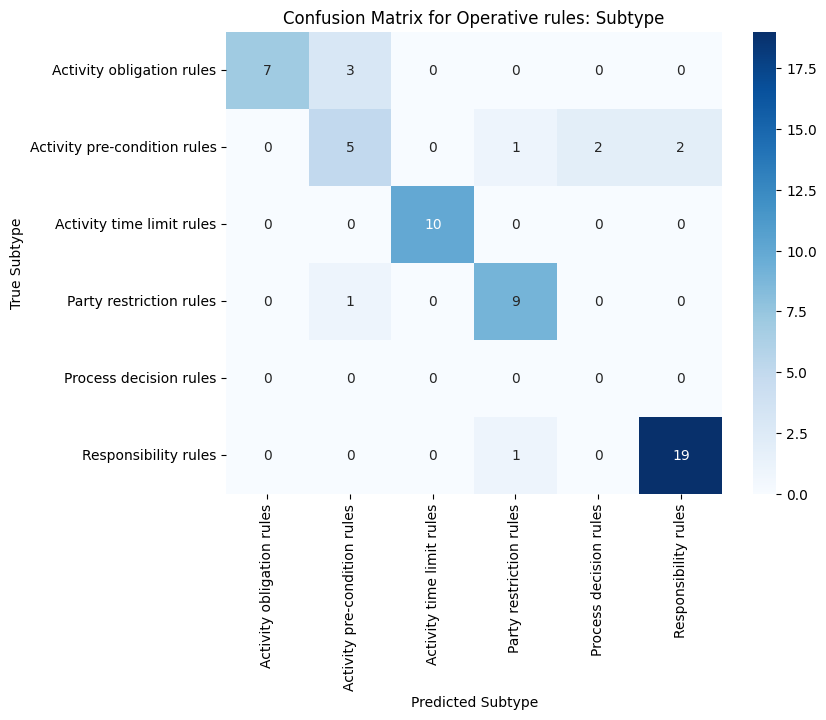

2024-12-22 00:50:06 - INFO - 0
2024-12-22 00:50:06 - INFO - []
2024-12-22 00:50:06 - INFO - 10
2024-12-22 00:50:06 - INFO - [({'doc_id': '§ 275.0-5', 'statement_id': '3', 'statement': 'An order disposing of the matter will be issued as of course following the expiration of the period of time referred to in paragraph (a) of this section, unless the Commission thereafter orders a hearing on the matter.', 'sources': ['(b)'], 'subtype': 'Activity obligation rules', 'templates_ids': ['T49']}, {'doc_id': '§ 275.0-5', 'statement_id': 3, 'statement_title': 'Issuance of order disposing of the matter', 'statement': 'An order disposing of the matter will be issued as of course following the expiration of the period of time referred to in paragraph (a) of this section, unless the Commission thereafter orders a hearing on the matter.', 'sources': ['(b)'], 'terms': [{'term': 'Order disposing of the matter', 'classification': 'Common Noun', 'confidence': 0.85, 'reason': 'The term describes a general 


Classification Report:
                              precision    recall  f1-score   support

   Activity obligation rules       1.00      0.70      0.82        10
Activity pre-condition rules       0.56      0.50      0.53        10
   Activity time limit rules       1.00      1.00      1.00        10
     Party restriction rules       0.82      0.90      0.86        10
      Process decision rules       0.00      0.00      0.00         0
        Responsibility rules       0.90      0.95      0.93        20

                    accuracy                           0.83        60
                   macro avg       0.71      0.67      0.69        60
                weighted avg       0.86      0.83      0.84        60



In [164]:
key = "subtype"
element_name = "operative rules"

cm_df, report_df, no_match, mismatch_docs = generate_metrics_with_report(
    [pred_doc for pred_doc in pred_fitered_list if "subtype" in pred_doc],
    true_operative_rules_p2_classify,
    key,
    element_name,
)

dataframes_list.append((f"{element_name} - CM {key}", cm_df))
dataframes_list.append((f"{element_name} - CR {key}", report_df))

logger.info(len(no_match))
logger.info(no_match)
logger.info(len(mismatch_docs))
logger.info(mismatch_docs)

List not matched rules.

In [165]:
sorted([
    f'{doc["doc_id"]} - {doc["sources"]} - {doc["statement_id"]} - {doc["subtype"]} - {doc["templates_ids"]}'
    for doc in no_match
])

[]

List misclassifications

In [166]:
sorted([
    f'{doc[0]["doc_id"]} - {doc[0]["sources"]} - {doc[0]["statement"]} - {doc[0]["subtype"]} - {doc[0]["templates_ids"]} - {doc[1]["subtype"]} - {doc[1]["templates_ids"]}'
    for doc in mismatch_docs
])

["§ 275.0-2 - ['(a)(2)'] - The Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission. - Responsibility rules - ['T56'] - Party restriction rules - ['T53']",
 "§ 275.0-5 - ['(a)'] - Any interested person may, within the period of time specified therein, submit to the Commission in writing any facts bearing upon the desirability of a hearing on the matter and may request that a hearing be held, stating his reasons therefor and the nature of his interest in the matter. - Party restriction rules - ['T53'] - Activity pre-condition rules - ['T50']",
 "§ 275.0-5 - ['(b)'] - An order disposing of the matter will be issued as of course following the expiration of the period of time referred to in paragraph (a) of this section, unless the Commission thereafter orders a hearing on the matter. - Activity obligation rules - ['T49'] - Activity pre-condition rules - ['T50']",
 "§ 

##### Facts and Fact types

In [167]:
# To get per doc_id use the pred_fitered_list
#pred_fitered_list = [pred_doc for pred_doc in pred_facts_classify if pred_doc["doc_id"] == "§ 275.0-7"]
pred_fitered_list = pred_facts_classify # All

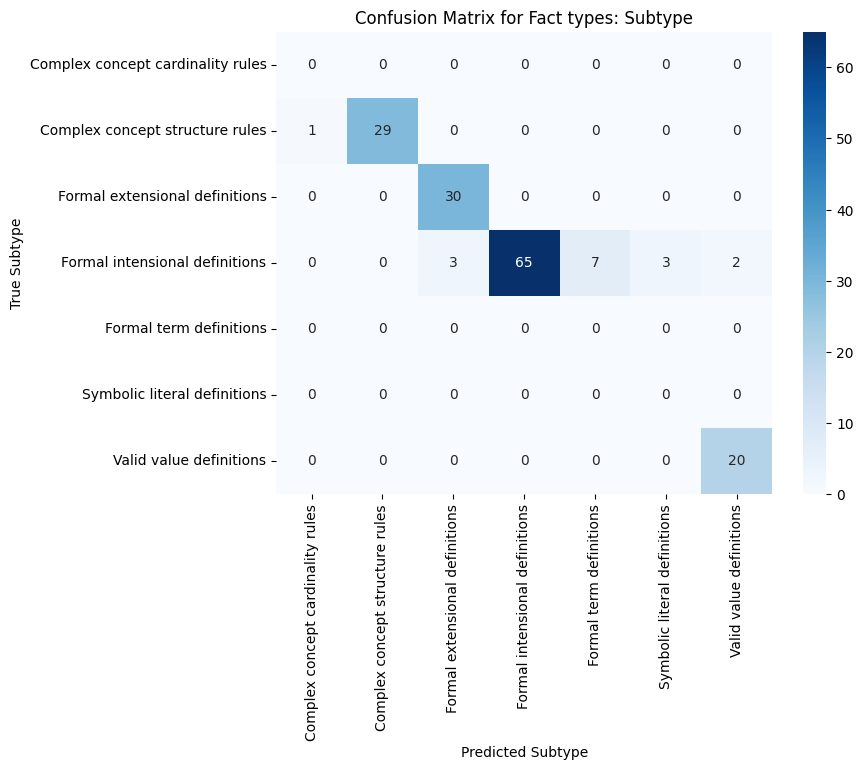

2024-12-22 00:50:06 - INFO - 0
2024-12-22 00:50:06 - INFO - []
2024-12-22 00:50:06 - INFO - 16
2024-12-22 00:50:06 - INFO - [({'doc_id': '§ 275.0-2', 'statement_id': '7', 'statement': 'Principal office and place of business has the same meaning as in § 275.203A-3(c) of this chapter.', 'sources': ['(b)(3)'], 'subtype': 'Formal intensional definitions', 'templates_ids': ['T7']}, {'doc_id': '§ 275.0-2', 'statement_id': 7, 'statement_title': 'Definition of Principal office and place of business', 'statement': 'Principal office and place of business has the same meaning as in § 275.203A-3(c) of this chapter.', 'sources': ['(b)(3)'], 'terms': [{'term': 'Principal office', 'classification': 'Common Noun', 'confidence': 0.9, 'reason': 'The term is defined within the context of the document.', 'extracted_confidence': 0.9, 'extracted_reason': 'The term is explicitly mentioned as the subject of the definition.'}, {'term': 'Place of business', 'classification': 'Common Noun', 'confidence': 0.9, 'r


Classification Report:
                                   precision    recall  f1-score   support

Complex concept cardinality rules       0.00      0.00      0.00         0
  Complex concept structure rules       1.00      0.97      0.98        30
   Formal extensional definitions       0.91      1.00      0.95        30
   Formal intensional definitions       1.00      0.81      0.90        80
          Formal term definitions       0.00      0.00      0.00         0
     Symbolic literal definitions       0.00      0.00      0.00         0
          Valid value definitions       0.91      1.00      0.95        20

                         accuracy                           0.90       160
                        macro avg       0.55      0.54      0.54       160
                     weighted avg       0.97      0.90      0.93       160



In [168]:
key = "subtype"
element_name = "fact types"

cm_df, report_df, no_match, mismatch_docs = generate_metrics_with_report(
    pred_fitered_list,
    true_facts_classify,
    key,
    element_name,
)

dataframes_list.append((f"{element_name} - CM {key}", cm_df))
dataframes_list.append((f"{element_name} - CR {key}", report_df))

logger.info(len(no_match))
logger.info(no_match)
logger.info(len(mismatch_docs))
logger.info(mismatch_docs)

List not matched rules.

In [169]:
sorted([
    f'{doc["doc_id"]} - {doc["sources"]} - {doc["statement_id"]} - {doc["subtype"]} - {doc["templates_ids"]}'
    for doc in no_match
])

[]

List misclassifications

In [170]:
sorted([
    f'{doc[0]["doc_id"]} - {doc[0]["sources"]} - {doc[0]["statement"]} - {doc[0]["subtype"]} - {doc[0]["templates_ids"]} - {doc[1]["subtype"]} - {doc[1]["templates_ids"]}'
    for doc in mismatch_docs
])

["§ 275.0-2 - ['(a)(1)'] - A person may serve a non-resident investment adviser, non-resident general partner, or non-resident managing agent by furnishing the Commission with one copy of the process, pleadings, or papers, for each named party, and one additional copy for the Commission's records. - Complex concept structure rules - ['T12'] - Complex concept cardinality rules - ['T12']",
 "§ 275.0-2 - ['(b)(3)'] - Principal office and place of business has the same meaning as in § 275.203A-3(c) of this chapter. - Formal intensional definitions - ['T7'] - Formal term definitions - ['T7']",
 "§ 275.0-2 - ['(b)(3)'] - Principal office and place of business has the same meaning as in § 275.203A-3(c) of this chapter. - Formal intensional definitions - ['T7'] - Formal term definitions - ['T7']",
 "§ 275.0-2 - ['(b)(3)'] - Principal office and place of business has the same meaning as in § 275.203A-3(c) of this chapter. - Formal intensional definitions - ['T7'] - Formal term definitions - ['T

##### Terms

In [171]:
# To get per doc_id use the pred_fitered_list
#pred_fitered_list = [pred_doc for pred_doc in pred_terms_classify if pred_doc["doc_id"] == "§ 275.0-7"]
pred_fitered_list = pred_terms_classify # All

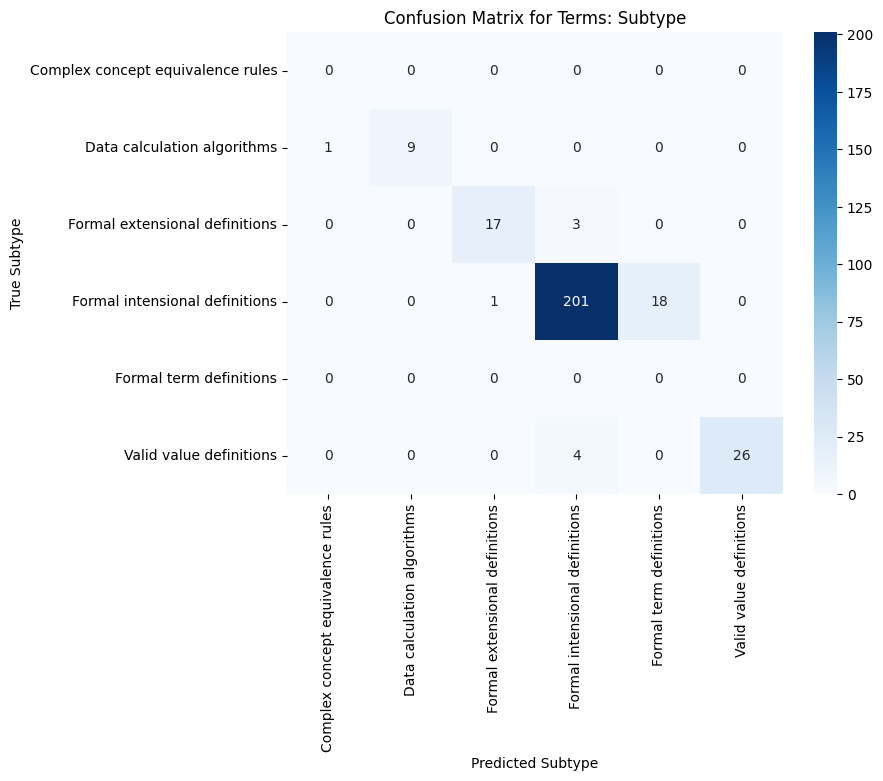

2024-12-22 00:50:07 - INFO - 0
2024-12-22 00:50:07 - INFO - []
2024-12-22 00:50:07 - INFO - 27
2024-12-22 00:50:07 - INFO - [({'doc_id': '§ 275.0-5', 'statement_id': 'Facts', 'statement': 'Information submitted to the Commission bearing upon the desirability of a hearing on the matter.', 'sources': ['(a)'], 'subtype': 'Formal intensional definitions', 'templates_ids': ['T7']}, {'doc_id': '§ 275.0-5', 'statement_id': 'Facts', 'definition': 'Information submitted to the Commission bearing upon the desirability of a hearing on the matter.', 'isLocalScope': True, 'sources': ['(a)'], 'element_name': 'Term', 'type': 'Definitional', 'subtype': 'Formal term definitions', 'confidence': 0.7, 'explanation': "The statement defines 'Facts' as 'Information submitted to the Commission', which aligns with a formal term definition. It specifies the nature of the information and its purpose, similar to how a formal intensional definition would specify characteristics. The lack of a hypernym reduces conf


Classification Report:
                                   precision    recall  f1-score   support

Complex concept equivalence rules       0.00      0.00      0.00         0
      Data calculation algorithms       1.00      0.90      0.95        10
   Formal extensional definitions       0.94      0.85      0.89        20
   Formal intensional definitions       0.97      0.91      0.94       220
          Formal term definitions       0.00      0.00      0.00         0
          Valid value definitions       1.00      0.87      0.93        30

                         accuracy                           0.90       280
                        macro avg       0.65      0.59      0.62       280
                     weighted avg       0.97      0.90      0.94       280



In [172]:
key = "subtype"
element_name = "terms"

cm_df, report_df, no_match, mismatch_docs = generate_metrics_with_report(
    pred_fitered_list,
    true_terms_classify,
    key,
    element_name,
)

dataframes_list.append((f"{element_name} - CM {key}", cm_df))
dataframes_list.append((f"{element_name} - CR {key}", report_df))

logger.info(len(no_match))
logger.info(no_match)
logger.info(len(mismatch_docs))
logger.info(mismatch_docs)

List not matched rules.

In [173]:
sorted([
    f'{doc["doc_id"]} - {doc["sources"]} - {doc["statement_id"]} - {doc["subtype"]} - {doc["templates_ids"]}'
    for doc in no_match
])

[]

List misclassifications

In [174]:
sorted([
    f'{doc[0]["doc_id"]} - {doc[0]["sources"]} - {doc[0]["statement"]} - {doc[0]["subtype"]} - {doc[0]["templates_ids"]} - {doc[1]["subtype"]} - {doc[1]["templates_ids"]}'
    for doc in mismatch_docs
])

["§ 275.0-2 - ['(a)(3)'] - The certification by the Secretary that the Commission was served with process, pleadings, or other papers and forwarded these documents to a named party. - Formal extensional definitions - ['T8'] - Formal intensional definitions - ['T7']",
 "§ 275.0-2 - ['(a)(3)'] - The certification by the Secretary that the Commission was served with process, pleadings, or other papers and forwarded these documents to a named party. - Formal extensional definitions - ['T8'] - Formal intensional definitions - ['T7']",
 "§ 275.0-2 - ['(a)(3)'] - The certification by the Secretary that the Commission was served with process, pleadings, or other papers and forwarded these documents to a named party. - Formal extensional definitions - ['T8'] - Formal intensional definitions - ['T7']",
 "§ 275.0-5 - ['(a)', '(b)'] - The timeframe specified in the notice during which interested persons can submit facts or request a hearing. - Valid value definitions - ['T15'] - Formal intensional

Misclassification with the same template

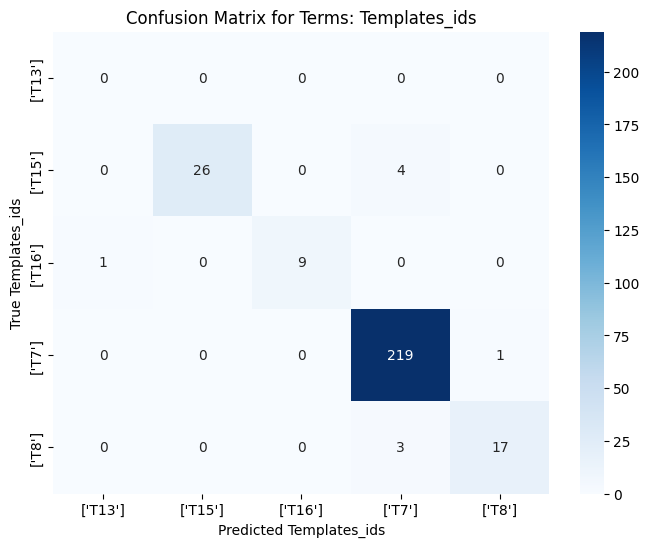

2024-12-22 00:50:07 - INFO - 0
2024-12-22 00:50:07 - INFO - []
2024-12-22 00:50:07 - INFO - 9
2024-12-22 00:50:07 - INFO - [({'doc_id': '§ 275.0-2', 'statement_id': 'Evidence of service', 'statement': 'The certification by the Secretary that the Commission was served with process, pleadings, or other papers and forwarded these documents to a named party.', 'sources': ['(a)(3)'], 'subtype': 'Formal extensional definitions', 'templates_ids': ['T8']}, {'doc_id': '§ 275.0-2', 'statement_id': 'Evidence of service', 'definition': 'The certification by the Secretary that the Commission was served with process, pleadings, or other papers and forwarded these documents to a named party.', 'isLocalScope': True, 'sources': ['(a)(3)'], 'element_name': 'Term', 'type': 'Definitional', 'subtype': 'Formal intensional definitions', 'confidence': 0.8, 'explanation': "The statement defines 'Evidence of service' by specifying the process of certification by the Secretary, which includes characteristics tha


Classification Report:
              precision    recall  f1-score   support

     ['T13']       0.00      0.00      0.00         0
     ['T15']       1.00      0.87      0.93        30
     ['T16']       1.00      0.90      0.95        10
      ['T7']       0.97      1.00      0.98       220
      ['T8']       0.94      0.85      0.89        20

    accuracy                           0.97       280
   macro avg       0.78      0.72      0.75       280
weighted avg       0.97      0.97      0.97       280



In [175]:
key = "templates_ids"
element_name = "terms"

cm_df, report_df, no_match, mismatch_docs = generate_metrics_with_report(
    pred_terms_classify,
    true_terms_classify,
    key,
    element_name,
)

dataframes_list.append((f"{element_name} - CM {key}", cm_df))
dataframes_list.append((f"{element_name} - CR {key}", report_df))

logger.info(len(no_match))
logger.info(no_match)
logger.info(len(mismatch_docs))
logger.info(mismatch_docs)

In [176]:
sorted([
    f'{doc[0]["doc_id"]} - {doc[0]["sources"]} - {doc[0]["statement"]} - {doc[0]["subtype"]} - {doc[0]["templates_ids"]} - {doc[1]["subtype"]} - {doc[1]["templates_ids"]}'
    for doc in mismatch_docs
])

["§ 275.0-2 - ['(a)(3)'] - The certification by the Secretary that the Commission was served with process, pleadings, or other papers and forwarded these documents to a named party. - Formal extensional definitions - ['T8'] - Formal intensional definitions - ['T7']",
 "§ 275.0-2 - ['(a)(3)'] - The certification by the Secretary that the Commission was served with process, pleadings, or other papers and forwarded these documents to a named party. - Formal extensional definitions - ['T8'] - Formal intensional definitions - ['T7']",
 "§ 275.0-2 - ['(a)(3)'] - The certification by the Secretary that the Commission was served with process, pleadings, or other papers and forwarded these documents to a named party. - Formal extensional definitions - ['T8'] - Formal intensional definitions - ['T7']",
 "§ 275.0-5 - ['(a)', '(b)'] - The timeframe specified in the notice during which interested persons can submit facts or request a hearing. - Valid value definitions - ['T15'] - Formal intensional

Investigating mismatches

How many terms in both sides?

In [177]:
len(pred_terms_classify), len(true_terms_classify)

(280, 28)

Looking for duplicate terms

In [178]:
# Track seen items and duplicates
seen_terms = set()
duplicates = []

# Check for duplicates by specified fields
for term in true_terms_classify:
    # Create a unique key from the specified fields
    key = (
        term["doc_id"],
        term["statement_id"],
        term["statement"],
        tuple(sorted(term["sources"])),
    )
    if key in seen_terms:
        duplicates.append(term)
    else:
        seen_terms.add(key)

# Output results
if duplicates:
    print("Duplicate entries found in true_terms based on specified fields:")
    for dup in duplicates:
        print(dup)
else:
    print("No duplicate entries found in true_terms based on specified fields.")

No duplicate entries found in true_terms based on specified fields.


##### Names

In [190]:
# To get per doc_id use the pred_fitered_list
#pred_fitered_list = [pred_doc for pred_doc in pred_names_classify if pred_doc["doc_id"] == "§ 275.0-5"]
pred_fitered_list = pred_names_classify # All

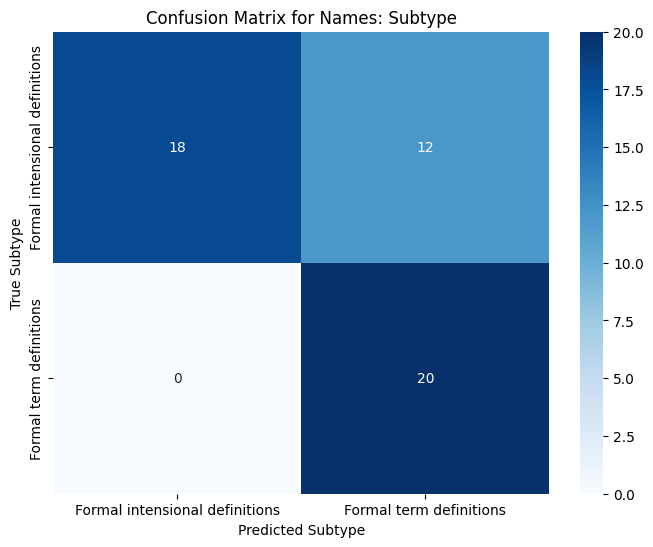

2024-12-22 00:55:57 - INFO - 0
2024-12-22 00:55:57 - INFO - []
2024-12-22 00:55:57 - INFO - 12
2024-12-22 00:55:57 - INFO - [({'doc_id': '§ 275.0-5', 'statement_id': 'Federal Register', 'statement': 'The official journal where the notice of initiation of the proceeding is published.', 'sources': ['(a)'], 'subtype': 'Formal intensional definitions', 'templates_ids': ['T7']}, {'doc_id': '§ 275.0-5', 'statement_id': 'Federal Register', 'definition': 'The official journal where the notice of initiation of the proceeding is published.', 'isLocalScope': True, 'sources': ['(a)'], 'element_name': 'Name', 'type': 'Definitional', 'subtype': 'Formal term definitions', 'confidence': 0.7, 'explanation': "This statement defines 'Federal Register' as an official journal, which serves as a hypernym. The statement provides a specific characteristic (publishing notices), aligning it with a formal intensional definition.", 'templates_ids': ['T7']}), ({'doc_id': '§ 275.0-5', 'statement_id': 'Commission', 


Classification Report:
                                precision    recall  f1-score   support

Formal intensional definitions       1.00      0.60      0.75        30
       Formal term definitions       0.62      1.00      0.77        20

                      accuracy                           0.76        50
                     macro avg       0.81      0.80      0.76        50
                  weighted avg       0.85      0.76      0.76        50



In [191]:
key = "subtype"
element_name = "names"

cm_df, report_df, no_match, mismatch_docs = generate_metrics_with_report(
    pred_fitered_list, true_names_classify, key, element_name
)

dataframes_list.append((f"{element_name} - CM {key}", cm_df))
dataframes_list.append((f"{element_name} - CR {key}", report_df))

logger.info(len(no_match))
logger.info(no_match)
logger.info(len(mismatch_docs))
logger.info(mismatch_docs)

List not matched rules.

In [181]:
sorted([
    f'{doc["doc_id"]} - {doc["sources"]} - {doc["statement_id"]} - {doc["subtype"]} - {doc["templates_ids"]}'
    for doc in no_match
])

[]

List misclassifications

In [182]:
sorted([
    f'{doc[0]["doc_id"]} - {doc[0]["sources"]} - {doc[0]["statement_id"]} - {doc[0]["subtype"]} - {doc[0]["templates_ids"]} - {doc[1]["subtype"]} - {doc[1]["templates_ids"]}'
    for doc in mismatch_docs
])

["§ 275.0-5 - ['(a)'] - Federal Register - Formal intensional definitions - ['T7'] - Formal term definitions - ['T7']",
 "§ 275.0-5 - ['(a)'] - Federal Register - Formal intensional definitions - ['T7'] - Formal term definitions - ['T7']",
 "§ 275.0-5 - ['(a)'] - Federal Register - Formal intensional definitions - ['T7'] - Formal term definitions - ['T7']",
 "§ 275.0-5 - ['(a)'] - Federal Register - Formal intensional definitions - ['T7'] - Formal term definitions - ['T7']",
 "§ 275.0-5 - ['(c)', '(a)', '(b)', '(d)'] - Commission - Formal intensional definitions - ['T7'] - Formal term definitions - ['T7']",
 "§ 275.0-5 - ['(c)', '(a)', '(b)', '(d)'] - Commission - Formal intensional definitions - ['T7'] - Formal term definitions - ['T7']",
 "§ 275.0-5 - ['(c)', '(a)', '(b)', '(d)'] - Commission - Formal intensional definitions - ['T7'] - Formal term definitions - ['T7']",
 "§ 275.0-5 - ['(c)', '(a)', '(b)', '(d)'] - Commission - Formal intensional definitions - ['T7'] - Formal term def

Misclassification with the same template

/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


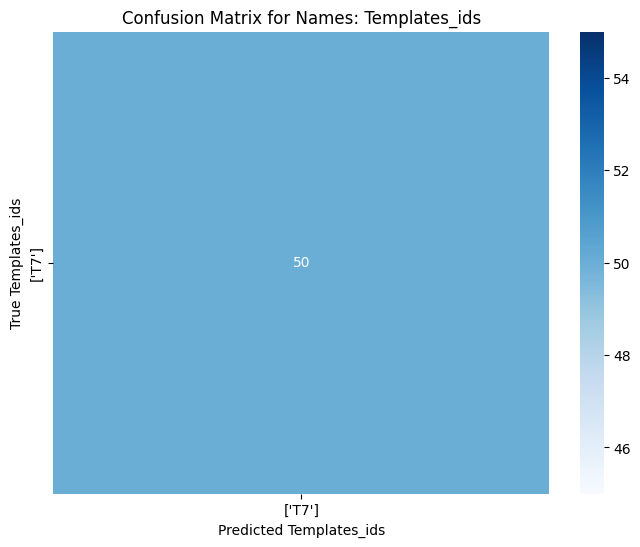

2024-12-22 00:56:06 - INFO - 0
2024-12-22 00:56:06 - INFO - []
2024-12-22 00:56:06 - INFO - 0
2024-12-22 00:56:06 - INFO - []



Classification Report:
              precision    recall  f1-score   support

      ['T7']       1.00      1.00      1.00        50

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [192]:
key = "templates_ids"
element_name = "names"

cm_df, report_df, no_match, mismatch_docs = generate_metrics_with_report(
    pred_names_classify, true_names_classify, key, element_name
)

dataframes_list.append((f"{element_name} - CM {key}", cm_df))
dataframes_list.append((f"{element_name} - CR {key}", report_df))

logger.info(len(no_match))
logger.info(no_match)
logger.info(len(mismatch_docs))
logger.info(mismatch_docs)

##### Save all accumulated DataFrames at the end

In [184]:
save_metrics_to_excel(dataframes_list, output_excel_path=f"{config['DEFAULT_OUTPUT_DIR']}/comparison_results.xlsx")

## Discussion

TODO